In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import os


In [4]:
def lim(lst, mx=10):
    return [x for x in lst][:mx]

In [2]:
# Read the sample data downloaded from the DMV testing web site
test_sample = pd.read_csv("OPT11022021-11042021.csv")


In [3]:
# Work with a shallow copy
df = test_sample.copy()


In [4]:
# Data prep

# Drop data with Result=NaN
print(f"{len(df)=} before dropping Nan")
df = df.dropna(subset=["Result"])
print(f"{len(df)=} after dropping Nan")


len(df)=4561 before dropping Nan
len(df)=4451 after dropping Nan


In [5]:
# Add column ip with the port number from the reported ip address
df["ip"] = df.IPAddress.apply(lambda x: np.nan if pd.isna(x) else x.split(":")[0])

In [6]:
# Add column result_std with NaN converted to None
df["result_std"] = df.Result.fillna("None")  


In [7]:
# Create column, duration, for the TotalTimeSpent in minutes
df["duration"] = df.TotalTimeSpent/60


In [8]:
# Some events have more than 1 ip address
df["multiple_ip"] = df.ip.apply( lambda x: len(x.split(","))>1)

In [9]:
df[df.multiple_ip]

,TestAttemptId,UserName,ExamineeId,TestId,LocaleId,TestLocationId,KioskId,KioskAssignDate,TestRegistrationDate,DownloadDate,...,LicClassCode,LicExpireDate,DriverPrivilegeCode,DriverStatusCode,ParentClientId,IPAddress.1,ip,result_std,duration,multiple_ip
100,5241586,NaN,1091968,5181,1033,705,NaN,NaN,11/2/2021 21:25,NaN,...,I,00:00.0,0.0,0.0,NaN,NaN,"165.155.218.145, 165.155.139.135",P,48.650000,True
178,5241749,NaN,2158824,5181,2058,705,NaN,NaN,11/2/2021 22:49,NaN,...,NaN,NaN,NaN,NaN,NaN,34.86.154.96:37478,"165.155.218.126, 165.155.140.118",P,78.116667,True
204,5238884,NaN,2396920,5181,2058,705,NaN,NaN,11/2/2021 11:27,NaN,...,NaN,NaN,NaN,NaN,NaN,34.86.154.96:55470,"165.155.226.74, 165.155.163.80",P,10.816667,True
554,5229966,NaN,2987871,5181,2058,705,NaN,NaN,10/29/2021 15:23,NaN,...,NaN,NaN,NaN,NaN,NaN,34.86.154.96:60774,"165.155.218.37, 165.155.139.32",F,18.966667,True
563,5245144,NaN,2988314,5181,2058,705,NaN,NaN,11/3/2021 17:24,NaN,...,NaN,NaN,NaN,NaN,NaN,34.145.184.172:35016,"165.155.226.26, 165.155.160.17",P,32.416667,True
824,5241373,NaN,2991872,5181,1033,705,NaN,NaN,11/2/2021 20:04,NaN,...,NaN,NaN,NaN,NaN,NaN,34.86.154.96:58362,"108.41.194.112, 165.225.220.184",P,12.433333,True
892,5237635,NaN,2992112,5181,2058,705,NaN,NaN,11/1/2021 23:57,NaN,...,NaN,NaN,NaN,NaN,NaN,35.221.42.251:40750,"165.155.218.115, 165.155.137.115",F,28.616667,True
893,5239148,NaN,2992112,5181,2058,705,NaN,NaN,11/2/2021 12:14,NaN,...,NaN,NaN,NaN,NaN,NaN,35.221.42.251:40750,"165.155.226.136, 165.155.163.130",P,35.266667,True
1086,5239190,NaN,2992754,5181,2058,705,NaN,NaN,11/2/2021 12:20,NaN,...,NaN,NaN,NaN,NaN,NaN,35.221.42.251:41340,"165.155.226.84, 165.155.163.65",P,5.616667,True
1151,5239519,NaN,2992897,5181,2058,705,NaN,NaN,11/2/2021 13:10,NaN,...,NaN,NaN,NaN,NaN,NaN,34.150.205.224:51458,"165.155.218.137, 165.155.138.134",F,8.616667,True


In [10]:
def plt_duration(df, vlines=12., cum=False):
    """Chart the test duration histogram for passing result"""
    # Start 10 x 8 figure and point to axes object
    fig = plt.figure(figsize=(15,8))
    ax = plt.axes()

    # Use hist for each passing result
    plt.hist(df[df.result_std == "P"]["duration"], bins=100, density=False, \
             histtype="step", cumulative=cum, linewidth=2, label='Pass')
    plt.hist(df[df.result_std == "F"]["duration"], bins=100, density=False, \
             histtype="step", cumulative=cum, linewidth=2, label='Fail')
    plt.hist(df[df.result_std == "None"]["duration"], bins=100, density=False, \
             histtype="step", cumulative=cum, linewidth=2, label='None')
    
    # Draw a vertical line at the first peak of the passing histogram
    ax.axvline(x=vlines, color="red", linewidth=4, ls=":", label=f"{vlines} min")
    
    plt.title('DMV - Test Duration by Test Result')
    plt.xlabel('Frequency')
    plt.ylabel('Duration (min)')
    plt.legend()   # Uses labels assigned in plt.hist

    plt.show

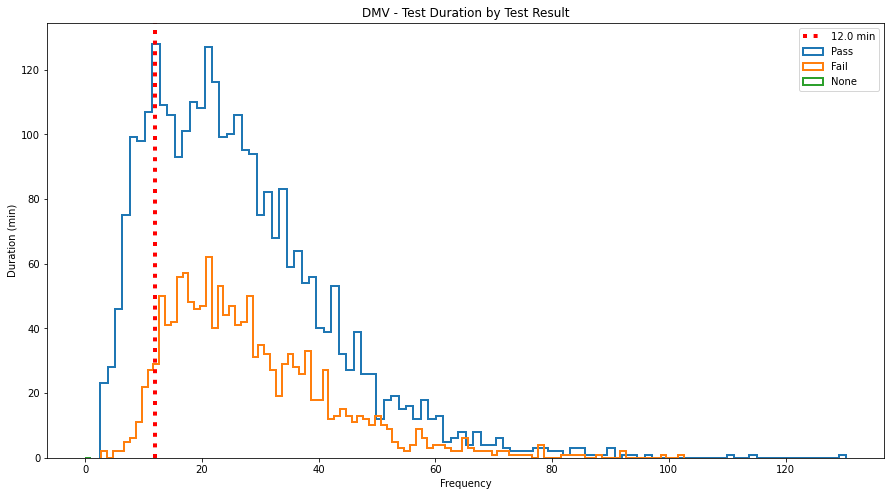

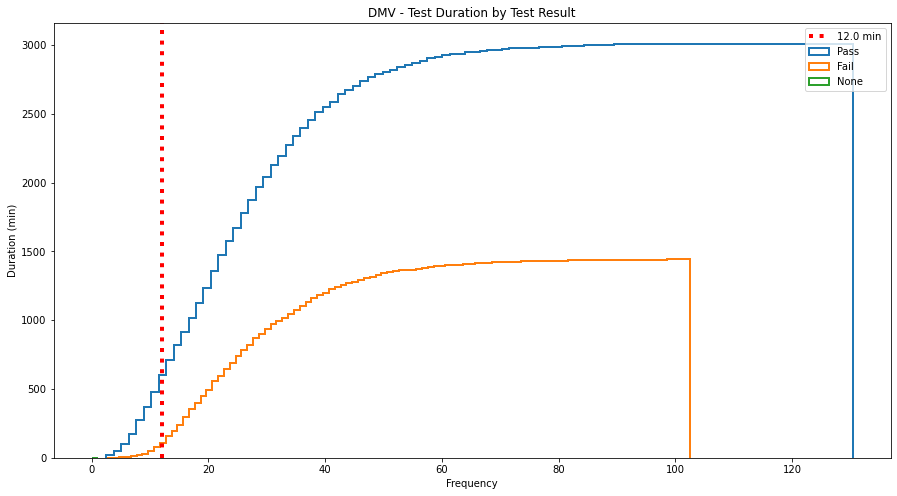

In [11]:
plt_duration(df)
plt_duration(df, cum=True)


In [12]:
# Find index 

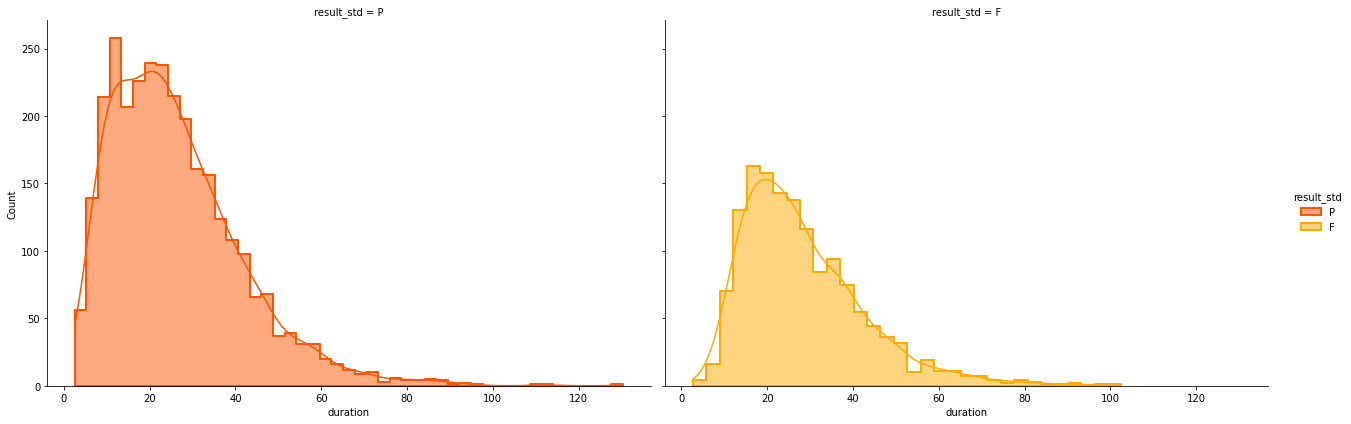

In [13]:
# Show same data using a different plotting package, displot. 
# displot can alse calculate the kde (kernel density estimate)
def displot_duration(df):
    g1 = sns.displot(data=df, x='duration', stat='count', kind='hist', cumulative=False, kde=True, col='result_std', \
                 hue='result_std', palette='autumn', aspect=1.5, element='step', height=6, \
                 fill=True, linewidth=2, common_bins=False, common_norm=False, \
                 facet_kws={'sharex':True, 'sharey':True}
                 )
    return g1

displot_duration(df)


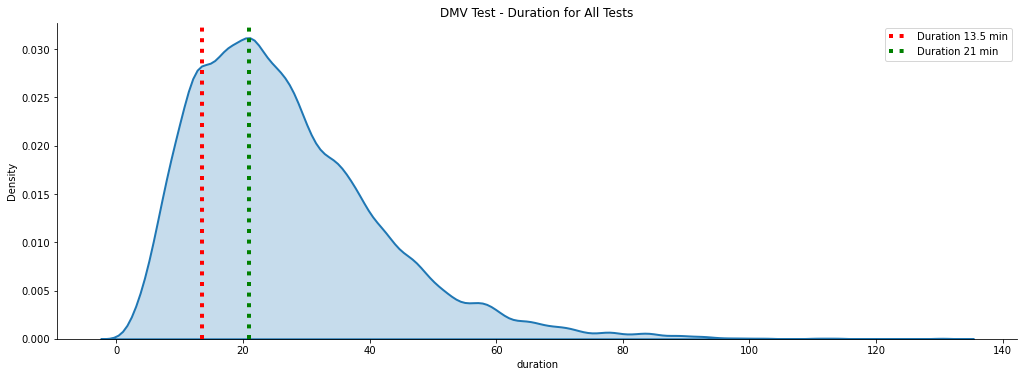

In [14]:
def displot_kde_duration_all(df, peak1=12, peak2=20, bw_adjust=0.6):
    
#     plt.figure(figsize=(12,6))
    # sns.displot(data=df, x='TotalTimeSpent', stat='count', kind='kde', cumulative=False, kde=True, bw_adjust=.25,\
    g = sns.displot(data=df, x='duration', kind='kde', cumulative=False, bw_adjust=bw_adjust,\
#                      hue='result_std', \
                     palette='prism', aspect=1.5, height=6, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )

    g.fig.set_figwidth(15)
    g.fig.set_figheight(5)

    plt.axvline(x=peak1, color="red", linewidth=4, ls=":", label=f"Duration {peak1} min")
    plt.axvline(x=peak2, color="green", linewidth=4, ls=":", label=f"Duration {peak2} min")
    plt.title("DMV Test - Duration for All Tests")
    plt.legend()
    return g


displot_kde_duration_all(df, peak1=13.5, peak2=21, bw_adjust=.6)

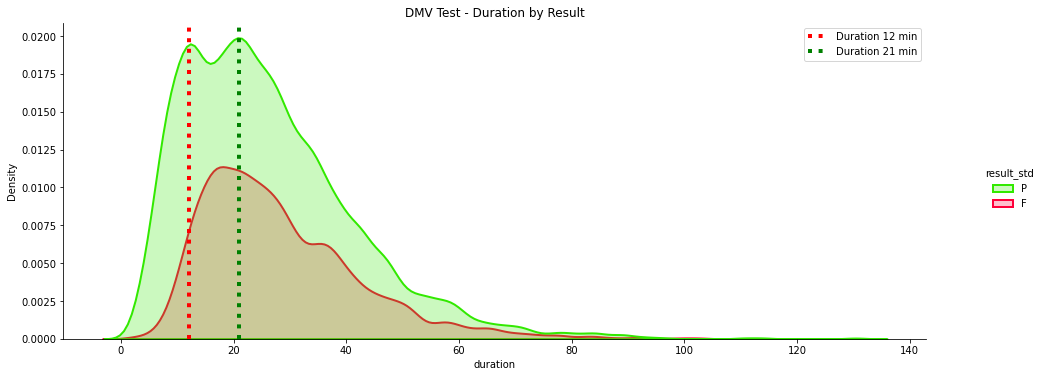

In [15]:
def displot_kde_duration(df, peak1=12, peak2=20, bw_adjust=0.6):
    
#     plt.figure(figsize=(12,6))
    # sns.displot(data=df, x='TotalTimeSpent', stat='count', kind='kde', cumulative=False, kde=True, bw_adjust=.25,\
    g = sns.displot(data=df, x='duration', kind='kde', cumulative=False, bw_adjust=bw_adjust,\
                     hue='result_std', palette='prism', aspect=1.5, height=6, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )

    g.fig.set_figwidth(15)
    g.fig.set_figheight(5)

    plt.axvline(x=peak1, color="red", linewidth=4, ls=":", label=f"Duration {peak1} min")
    plt.axvline(x=peak2, color="green", linewidth=4, ls=":", label=f"Duration {peak2} min")
    plt.title("DMV Test - Duration by Result")
    plt.legend()
    return g

g = displot_kde_duration(df, peak2=21)

The passed tests are bimodal with an early peak around 12 min. DMV officials think that the test should take more than 5 minutes. In fact, very few of the failing tests take less than 5 minutes. 

The dstribution of failed tests is unimodal with a slight broadening.

In [16]:
def displot_kde_passed_partitions(df, quartiles, bw_adjust=0.6):
    
#     plt.figure(figsize=(12,6))
    # sns.displot(data=df, x='TotalTimeSpent', stat='count', kind='kde', cumulative=False, kde=True, bw_adjust=.25,\
    g = sns.displot(data=df, x='duration', kind='kde', cumulative=False, bw_adjust=bw_adjust,\
                     hue='result_std', palette='prism', aspect=1.5, height=6, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )

    g.fig.set_figwidth(15)
    g.fig.set_figheight(5)

    plt.vlines(quartiles, 0, 0.03, linewidth=2, ls=":")
#     plt.axvline(x=peak2, color="green", linewidth=4, ls=":", label=f"Duration {peak2} min")
    plt.title("DMV Test - Duration for Passed Tests - by Result - Shows Quartiles")
    plt.legend(labels=["Passed", "25%", "50%", "75%"])
    return g

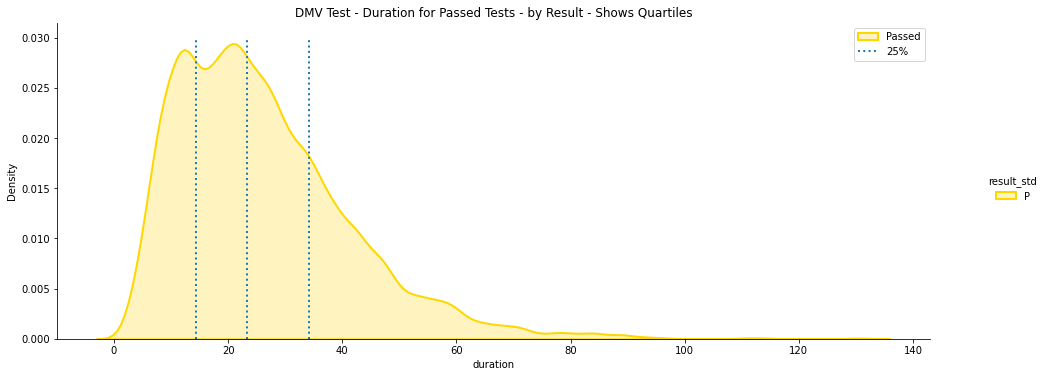

In [17]:
quartiles={ x:df[df.result_std==x]["duration"].describe() for x in ["P","F"] }
g = displot_kde_passed_partitions(df[df.result_std=="P"], list(quartiles["P"][["25%", "50%", "75%"]]) ) 

In [18]:
# Add column suspect when TotalTimeSpent <= 5m (or 6.5m)
fastest = 12
passed = pd.DataFrame(df[df.result_std=="P"])


In [19]:
passed["suspect"] = passed.duration.apply(lambda x: "suspect" if x <= fastest else "ok")

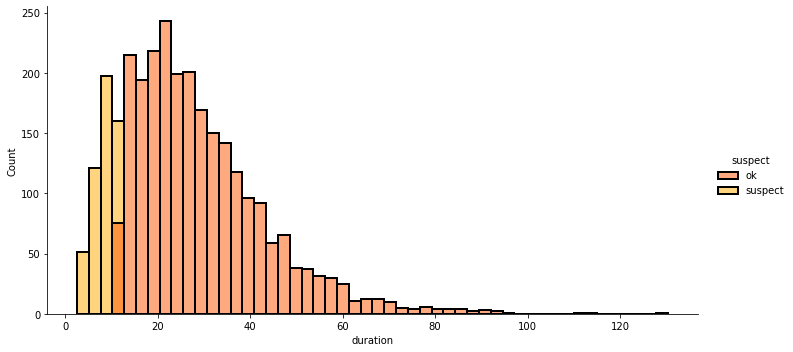

In [20]:
def displot_suspect(df, bw_adjust=0.9):
    
    
    g1 = sns.displot(data=df, x='duration', hue='suspect', \
                     kind='hist', bins=50, \
                     stat="count", \
                     palette='autumn', aspect=2, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )
#     g1.fig.set_figwidth=(15)
#     g1.fig.set_figheight=(5)
#     plt.axvline(x=fastest, color="red", linewidth=4, ls=":", label="5 min")

displot_suspect(passed)

In [21]:
def displot_2suspect(df, base="TotalQuestionsCorrect", compare="duration", suspect=True, fastest=15, bw_adjust=0.9):
    # Scatter plot showing the total questions that are answered correctly
    # by the total time to answer
    
    df.loc["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "ok")
    
    case = "suspect" if suspect else "ok"
    
    sns.displot(data=df[df.suspect==case], x=compare, y='duration', \
                     kind="kde", \
                     palette='autumn', aspect=1, \
                     bins=10, \
                     )
    plt.title(f"{compare} vs Duration of Passed Tests {' <= ' if case=='suspect' else ' > '}{fastest} min ")


/home/bkrawchuk/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(
/home/bkrawchuk/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(


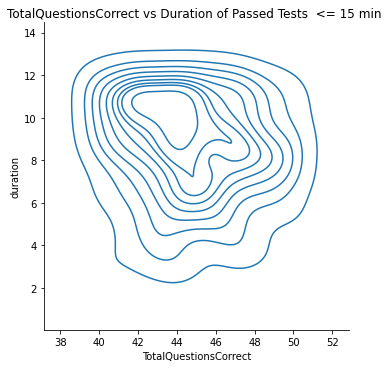

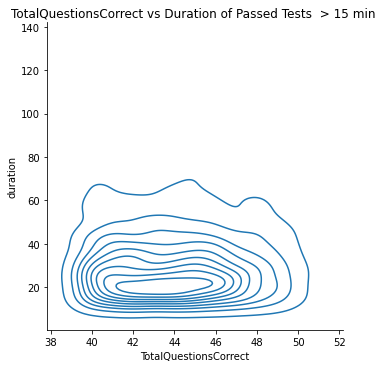

In [22]:
# 
# displot_2suspect(passed[passed.suspect=="ok"])
# displot_2suspect(passed[passed.suspect=="suspect"])

displot_2suspect(passed, compare="TotalQuestionsCorrect", suspect=True, fastest=15)
displot_2suspect(passed, compare="TotalQuestionsCorrect", suspect=False, fastest=15)

For test taking more than 15 minutes there's a uniform number of correctly answered questions bewtween 41 an 47. For tests that take less than 15 min, it is not so uniform. There are a high numer of excellent score >48 for test that take 7-9 minutes. There's more very high scoring tests at 7-8 minutes. The number of correct answers appears to be trending to uniformity above 10 minutes.

In [23]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def displot_xy(df, 
               base="TotalQuestionsCorrect", 
               compare="duration", 
               suspect=True, 
               fastest=12, 
               bw_adjust=0.9, 
               nminor = 1,
               bins=10):
    
    # Scatter plot showing the total questions that are answered correctly
    # by the total time to answer
    
    df["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "not suspected")
    
    case = "suspect" if suspect else "not suspected"
    g = sns.displot(data=df[df.suspect==case], x=base, y=compare, \
#                      kind="kde", \
                     palette='autumn', aspect=1, \
                     bins=bins, \
                     cbar=True, \
                     )
    g.ax.yaxis.set_minor_locator(AutoMinorLocator(nminor + 1))
    plt.title(f"{base} vs {compare} {' <= ' if case=='suspected' else ' > '}{fastest} min ")

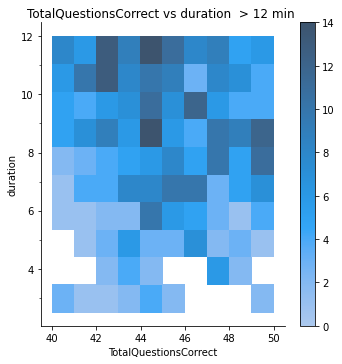

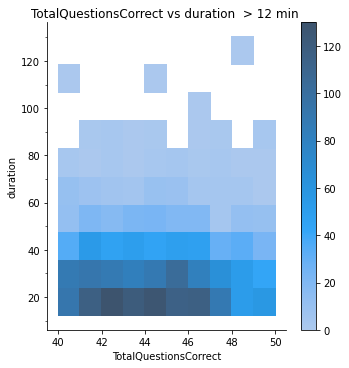

In [24]:
displot_xy(passed)
displot_xy(passed, suspect=False)


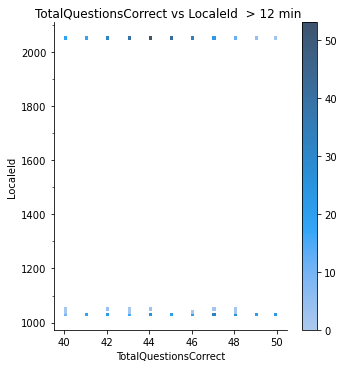

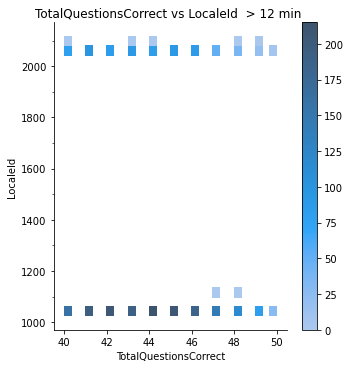

In [25]:
displot_xy(passed, compare="LocaleId", bins=100)
displot_xy(passed, suspect=False, compare="LocaleId", bins=30)

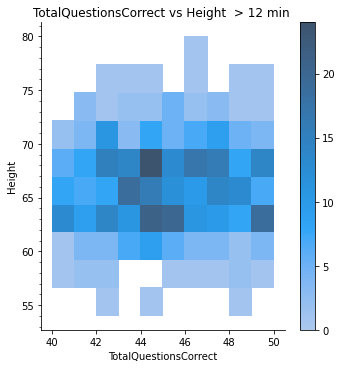

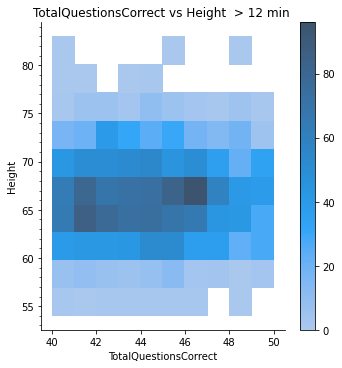

In [26]:
displot_xy(passed, base="TotalQuestionsCorrect", compare="Height", bins=10, nminor=4)
displot_xy(passed, suspect=False, base="TotalQuestionsCorrect", compare="Height", bins=10, nminor=4)

In [27]:
# Whois extraction
with open("whois_msg.txt") as fin:
    whois_msg = fin.readlines()
def read_whois(msg):

    p_netrange = re.compile(r"NetRange:\W*([^ ]*) - (.*)")
    p_cidr     = re.compile(r"CIDR:\W*(.*)")
    p_orgname  = re.compile(r"OrgName:\W*(.*)")
    for l in msg:
        m = p_netrange.match(l.rstrip())
        if m:
            netlo, nethi = m.group(1), m.group(2)
            print(f"{netlo = } {nethi =}")
        m = p_cidr.match(l.rstrip())
        if m:
            cidr = m.group(1)
            print(f"{cidr = }")
        m = p_orgname.match(l.rstrip())
        if m:
            orgname = m.group(1)
            print(f"{orgname = }")


read_whois(whois_msg)

netlo = '142.255.0.0' nethi ='142.255.127.255'
cidr = '142.255.0.0/17'
orgname = 'Charter Communications Inc'


In [28]:
dcl

4451

In [29]:
def ips_that_are_duplicated(df):
    d = {}
    for ip in df.ip:
        if ip in d:
            d[ip] += 1
        else:
            d[ip] = 1
    return { k:v for k,v in d.items() if v > 1 }

len(ips_that_are_duplicated(df))


645

In [30]:
df[df.ip.duplicated(keep=False)]\
[["ip", "TestStartDateTime", "Result", "TotalQuestionsCorrect", "TotalTimeSpent", "Email", "Token"]]\
.sort_values(by=["ip", "TestStartDateTime"], axis="rows")


,ip,TestStartDateTime,Result,TotalQuestionsCorrect,TotalTimeSpent,Email,Token
3871,100.12.122.32,11/4/2021 14:41,F,37,897,andyc1115@gmail.com,KKEQRDW
3872,100.12.122.32,11/4/2021 21:02,P,41,826,andyc1115@gmail.com,KKEQRDW
1850,100.12.197.98,11/2/2021 21:34,P,46,1007,daniela250803@gmail.com,ADYGCX
3937,100.12.197.98,11/4/2021 15:28,P,44,747,d8602075@gmail.com,XZ8OHIX
4029,100.12.205.241,11/4/2021 17:17,F,34,800,joegagliano1721@gmail.com,N3WQP4P
...,...,...,...,...,...,...,...
3629,98.15.40.143,11/3/2021 23:52,P,41,2329,betonaxi83@gmail.com,JINWH
4341,98.15.40.143,11/4/2021 22:23,P,49,1330,Felicianosua@gmail.com,LPGNZON
1345,98.15.51.183,11/2/2021 15:46,P,45,473,carlos-diaz1990@outlook.com,CFP62A6
2370,98.15.51.183,11/3/2021 16:59,P,43,474,catherine-argote92@outlook.com,73FNRD6


<ipython-input-23-17fe6e01ba81>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "not suspected")


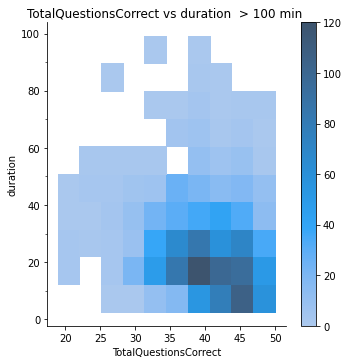

In [31]:

displot_xy(df[df.ip.duplicated(keep=False)], base="TotalQuestionsCorrect", compare="duration", suspect=True, fastest=100, bw_adjust=0.9, bins=10)

In [32]:
pd.options.display.min_rows=0
pd.options.display.max_rows=50


In [33]:
df1 = df[df.ip.duplicated(keep=False)][["ip", "TestStartDateTime", "Result", "Email"]]
df1

,ip,TestStartDateTime,Result,Email
2,72.68.212.63,11/3/2021 17:33,F,anevybrewster@gmail.com
8,24.189.68.18,11/3/2021 14:43,F,kilifeu77@gmail.com
9,172.58.235.43,11/3/2021 1:03,P,Jenkinsvalerie725@gmail.com
11,45.47.241.178,11/3/2021 13:40,F,maxraymonde@gmail.com
16,74.77.119.233,11/3/2021 8:15,P,neneboricua2010@gmail.com
17,74.77.119.233,11/2/2021 21:01,F,neneboricua2010@gmail.com
18,74.77.119.233,11/2/2021 14:34,F,neneboricua2010@gmail.com
19,74.77.119.233,11/2/2021 8:04,F,neneboricua2010@gmail.com
22,72.231.177.137,11/3/2021 17:23,F,anasctt296@gmail.com
23,72.231.177.137,11/3/2021 9:13,F,anasctt296@gmail.com


In [34]:
df1[df1.ip=="100.12.122.32"]

,ip,TestStartDateTime,Result,Email
3871,100.12.122.32,11/4/2021 14:41,F,andyc1115@gmail.com
3872,100.12.122.32,11/4/2021 21:02,P,andyc1115@gmail.com


In [35]:
# List the ip addresses inside a netword defined using cidr

import ipaddress

# ip1 = ipaddress.IPv4Network("10.0.0.0/24")
# for i, ip in enumerate(ip1):
#     print(ip, end=" ")
# print(f"{i=}")